In [7]:
pip install bioinfokit

     ---------------------------------------- 0.0/88.1 kB ? eta -:--:--
     -------- ----------------------------- 20.5/88.1 kB 330.3 kB/s eta 0:00:01
     -------------------------- ----------- 61.4/88.1 kB 656.4 kB/s eta 0:00:01
     -------------------------------------- 88.1/88.1 kB 714.1 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for matplotlib-venn from https://files.pythonhosted.org/packages/b1/f4/12ea88962cd17acb58bfcce1b93ce256f591698f9adb247de3eea630f590/matplotlib_venn-0.11.10-py3-none-any.whl.metadata
  Obtaining dependency information for textwrap3 from https://files.pythonhosted.org/packages/77/9c/a53e561d496ee5866bbeea4d3a850b3b545ed854f8a21007c1e0d872e94d/textwrap3-0.9.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for adjustText from https://files.pythonhosted.org/packages/71/0d/baaa8e9f8c14e33f353419f7c7da4c270145626f043e98740e743ece6a8e/

In [168]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from joblib import Parallel, delayed
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from bioinfokit.visuz import cluster
from scipy.stats import entropy
from sklearn.mixture import GaussianMixture
from patsy import dmatrices
from patsy import dmatrix
from statsmodels.graphics.mosaicplot import mosaic
from itertools import product
from sklearn.preprocessing import LabelEncoder


# Suppress all warnings
##warnings.simplefilter('ignore')

In [200]:
df=pd.read_csv('mcdonalds.csv')

In [10]:
df.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,Once a month,Male


In [11]:
md = df.drop(columns=['Like','Age','VisitFrequency','VisitFrequency','Gender'], axis=1)
md

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
1448,No,Yes,No,Yes,Yes,No,No,No,Yes,No,Yes
1449,Yes,Yes,No,Yes,No,No,Yes,Yes,No,Yes,No
1450,Yes,Yes,No,Yes,No,Yes,No,Yes,Yes,No,No
1451,Yes,Yes,No,No,No,Yes,Yes,Yes,No,Yes,No


In [12]:
md_x = np.array(md)
md_x

array([['No', 'Yes', 'No', ..., 'Yes', 'No', 'No'],
       ['Yes', 'Yes', 'No', ..., 'Yes', 'No', 'No'],
       ['No', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'No'],
       ...,
       ['Yes', 'Yes', 'No', ..., 'Yes', 'No', 'No'],
       ['Yes', 'Yes', 'No', ..., 'No', 'Yes', 'No'],
       ['No', 'Yes', 'No', ..., 'Yes', 'No', 'Yes']], dtype=object)

In [13]:
md_x[md_x=='No'] = 0
md_x[md_x=='Yes'] = 1
md_x

array([[0, 1, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 1, 0, 0],
       [0, 1, 1, ..., 1, 1, 0],
       ...,
       [1, 1, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 0, 1]], dtype=object)

In [14]:
mdm = pd.DataFrame(md_x, columns=[f"Var{i+1}" for i in range(md_x.shape[1])])
mdm

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11
0,0,1,0,1,0,1,1,0,1,0,0
1,1,1,0,1,1,1,1,1,1,0,0
2,0,1,1,1,1,1,0,1,1,1,0
3,1,1,0,1,1,1,1,1,0,0,1
4,0,1,0,1,1,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1448,0,1,0,1,1,0,0,0,1,0,1
1449,1,1,0,1,0,0,1,1,0,1,0
1450,1,1,0,1,0,1,0,1,1,0,0
1451,1,1,0,0,0,1,1,1,0,1,0


In [15]:
mean = np.mean(mdm,axis=0)
mean

Var1      0.55265
Var2     0.907777
Var3     0.093599
Var4     0.867171
Var5     0.526497
Var6     0.900206
Var7     0.598761
Var8     0.644184
Var9      0.35788
Var10    0.198899
Var11    0.242946
dtype: object

In [16]:
a=0
b=1
c=''
column  = md.columns
for a in range(0,mean.shape[0]):
    c = column[a]
    print(f'{c}: {mean[a]}\n')

yummy: 0.5526496902959395

convenient: 0.9077770130763937

spicy: 0.09359944941500344

fattening: 0.8671713695801789

greasy: 0.5264969029593943

fast: 0.9002064693737095

cheap: 0.5987611837577426

tasty: 0.6441844459738472

expensive: 0.35788024776324845

healthy: 0.1988988300068823

disgusting: 0.2429456297315898



In [17]:
pca = PCA()
pca.fit(mdm)

PCA()

In [18]:
mdpc= pca.transform(mdm)

In [19]:
pca.explained_variance_

array([0.57312398, 0.36900226, 0.2546408 , 0.15904032, 0.11384214,
       0.09627033, 0.08392454, 0.07569209, 0.07035814, 0.06192225,
       0.05612296])

In [20]:
## variance 
v = pca.explained_variance_
## explained_variance_ratio
evr = pca.explained_variance_ratio_
## cumulative_explained_variance
cev = np.cumsum(evr)
## Standed Deviation
sd = np.sqrt(v)

In [21]:
matrix = np.vstack((sd,evr,cev))
matrix

array([[0.75704952, 0.60745556, 0.50461946, 0.39879859, 0.33740501,
        0.31027461, 0.28969732, 0.27512196, 0.2652511 , 0.24884182,
        0.23690284],
       [0.29944723, 0.19279721, 0.13304535, 0.08309578, 0.05948052,
        0.05029956, 0.0438491 , 0.03954779, 0.0367609 , 0.03235329,
        0.02932326],
       [0.29944723, 0.49224445, 0.6252898 , 0.70838558, 0.7678661 ,
        0.81816566, 0.86201476, 0.90156255, 0.93832345, 0.97067674,
        1.        ]])

In [22]:
summary = pd.DataFrame(matrix,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11'])


In [23]:
summary.index = ['Standard deviation','Proportion of Variance','Cumulative Proportion']
summary

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
Standard deviation,0.757050,0.607456,0.504619,0.398799,0.337405,0.310275,0.289697,0.275122,0.265251,0.248842,0.236903
Proportion of Variance,0.299447,0.192797,0.133045,0.083096,0.059481,0.050300,0.043849,0.039548,0.036761,0.032353,0.029323
Cumulative Proportion,0.299447,0.492244,0.625290,0.708386,0.767866,0.818166,0.862015,0.901563,0.938323,0.970677,1.000000


In [24]:
sdr = np.round(sd,1)
sdr

array([0.8, 0.6, 0.5, 0.4, 0.3, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2])

In [25]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
mdt = np.transpose(pca.components_)

In [26]:
mdpca=pd.DataFrame(mdt,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11'])
mdpca
mdpca.index= ['yummy','convenient','spicy','fattening','greasy','fast','cheap','tasty','expensive','healthy','disgusting']
mdpca1= mdpca *-1
mdpca1

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
yummy,0.476933,-0.363790,0.304444,-0.055162,0.307535,-0.170738,0.280519,-0.013041,-0.572403,0.110284,-0.045439
convenient,0.155332,-0.016414,0.062515,0.142425,-0.277608,0.347830,0.059738,0.113079,0.018465,0.665818,0.541616
spicy,0.006356,-0.018809,0.037019,-0.197619,-0.070620,0.355087,-0.707637,-0.375934,-0.400280,0.075634,-0.141730
fattening,-0.116232,0.034094,0.322359,0.354139,0.073405,0.406515,0.385943,-0.589622,0.160512,0.005338,-0.250910
greasy,-0.304443,0.063839,0.802373,-0.253960,-0.361399,-0.209347,-0.036170,0.138241,0.002847,-0.008707,-0.001642
fast,0.108493,0.086972,0.064642,0.097363,-0.107930,0.594632,0.086846,0.627799,-0.166197,-0.239532,-0.339265
cheap,0.337186,0.610633,0.149310,-0.118958,0.128973,0.103241,0.040449,-0.140060,-0.076069,-0.428087,0.489283
tasty,0.471514,-0.307318,0.287265,0.002547,0.210899,0.076914,-0.360453,0.072792,0.639086,-0.079184,-0.019552
expensive,-0.329042,-0.601286,-0.024397,-0.067816,0.003125,0.261342,0.068385,-0.029539,-0.066996,-0.454399,0.490069
healthy,0.213711,-0.076593,-0.192051,-0.763488,-0.287846,0.178226,0.349616,-0.176303,0.185572,0.038117,-0.157608


In [27]:
a= ['yummy','convenient','spicy','fattening','greasy','fast','cheap','tasty','expensive','healthy','disgusting']

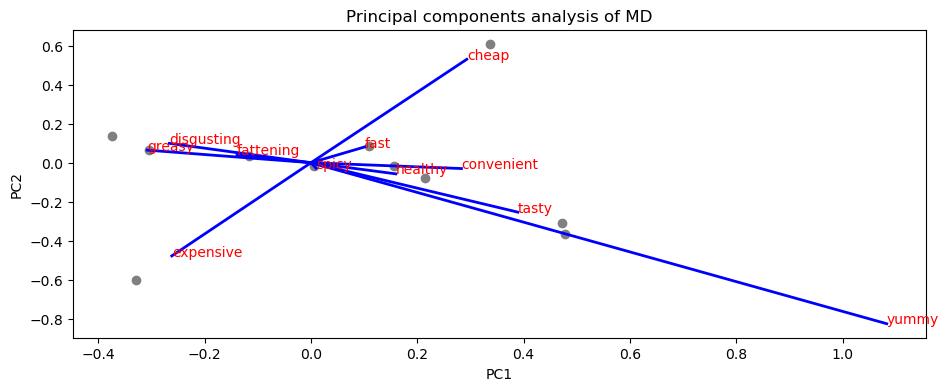

In [28]:
plt.figure(figsize=(11,4))
plt.scatter(x= mdpca1['PC1'], y = mdpca1['PC2'], color='grey')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Principal components analysis of MD')
for i, (length, vector,b) in enumerate(zip(pca.explained_variance_, mdt*-1,a)):
    v = vector * 3 * np.sqrt(length)
    plt.plot([0, v[0]], [0, v[1]], color='blue', linewidth = 2)
    plt.text(v[0], v[1], f"{b}", color='red')

## Extracting Segments

## k-Means

In [85]:

def step_kmeans(data):
    np.random.seed(1234)
    nrep = 10
    num_segments = range(1, 9)
    clustering_results = {}
    inertia = []
    for k in num_segments:
        kmeans = KMeans(n_clusters=k, n_init=nrep, random_state=1234)
        kmeans.fit(data)
        inertia.append((kmeans.inertia_))
        clustering_results[str(k)] = kmeans
    return clustering_results, inertia


MD_km28, inertia = step_kmeans(MD)

MD_km28


Text(0.5, 1.0, 'Scree plot for the fast food data set')

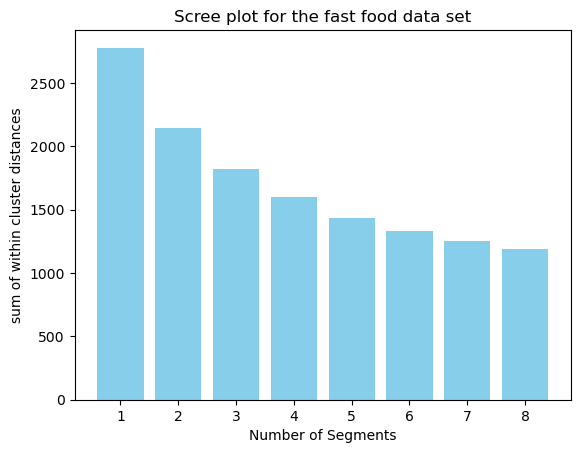

In [88]:
plt.bar(range(1, 9), inertia, color='skyblue')
plt.xlabel('Number of Segments')
plt.ylabel('sum of within cluster distances')
plt.title('Scree plot for the fast food data set')


In [37]:
np.random.seed(1234)

In [43]:
scaler = StandardScaler()
MD_x_scaled = scaler.fit_transform(md_x)
MD_x_scaled

array([[-1.11147857,  0.31873518, -0.32134871, ...,  1.339489  ,
        -0.49827882, -0.56648839],
       [ 0.89970246,  0.31873518, -0.32134871, ...,  1.339489  ,
        -0.49827882, -0.56648839],
       [-1.11147857,  0.31873518,  3.11188424, ...,  1.339489  ,
         2.00690848, -0.56648839],
       ...,
       [ 0.89970246,  0.31873518, -0.32134871, ...,  1.339489  ,
        -0.49827882, -0.56648839],
       [ 0.89970246,  0.31873518, -0.32134871, ..., -0.74655335,
         2.00690848, -0.56648839],
       [-1.11147857,  0.31873518, -0.32134871, ...,  1.339489  ,
        -0.49827882,  1.76526126]])

In [41]:
def bootstrap_kmeans(data, min_clusters, max_clusters, nrep=10, nboot=100):
        stability = []
        for _ in range(nboot):
            data_boot = resample(data.values,random_state=1234)
            stability.append(data_boot)
            # Perform k-means clustering nrep times and choose the best result
            best_inertia = np.inf
            for _ in range(nrep):
                kmeans = KMeans(n_clusters=n_clusters,n_init=10, random_state=None).fit(data_boot)
                if kmeans.inertia_ < best_inertia:
                    best_inertia = kmeans.inertia_
            stability.append(best_inertia)
        boot_results[n_clusters] = np.mean(stability)
    return boot_results

In [47]:
MD = pd.DataFrame(md_x)

,0,1,2,3,4,5,6,7,8,9,10
0,0,1,0,1,0,1,1,0,1,0,0
1,1,1,0,1,1,1,1,1,1,0,0
2,0,1,1,1,1,1,0,1,1,1,0
3,1,1,0,1,1,1,1,1,0,0,1
4,0,1,0,1,1,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1448,0,1,0,1,1,0,0,0,1,0,1
1449,1,1,0,1,0,0,1,1,0,1,0
1450,1,1,0,1,0,1,0,1,1,0,0
1451,1,1,0,0,0,1,1,1,0,1,0


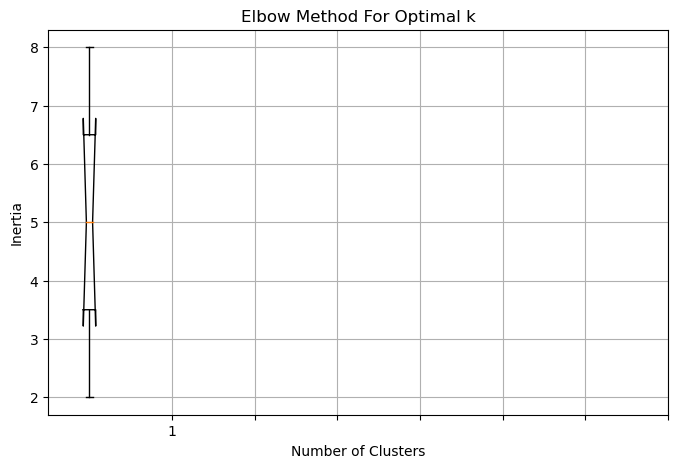

In [33]:
plt.figure(figsize=(8, 5))
plt.boxplot(range(min_clusters, max_clusters + 1), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(range(min_clusters, max_clusters + 1))
plt.grid(True)
plt.show()

In [65]:
MD_km28[str(3)]

KMeans(n_init=10, random_state=1234)

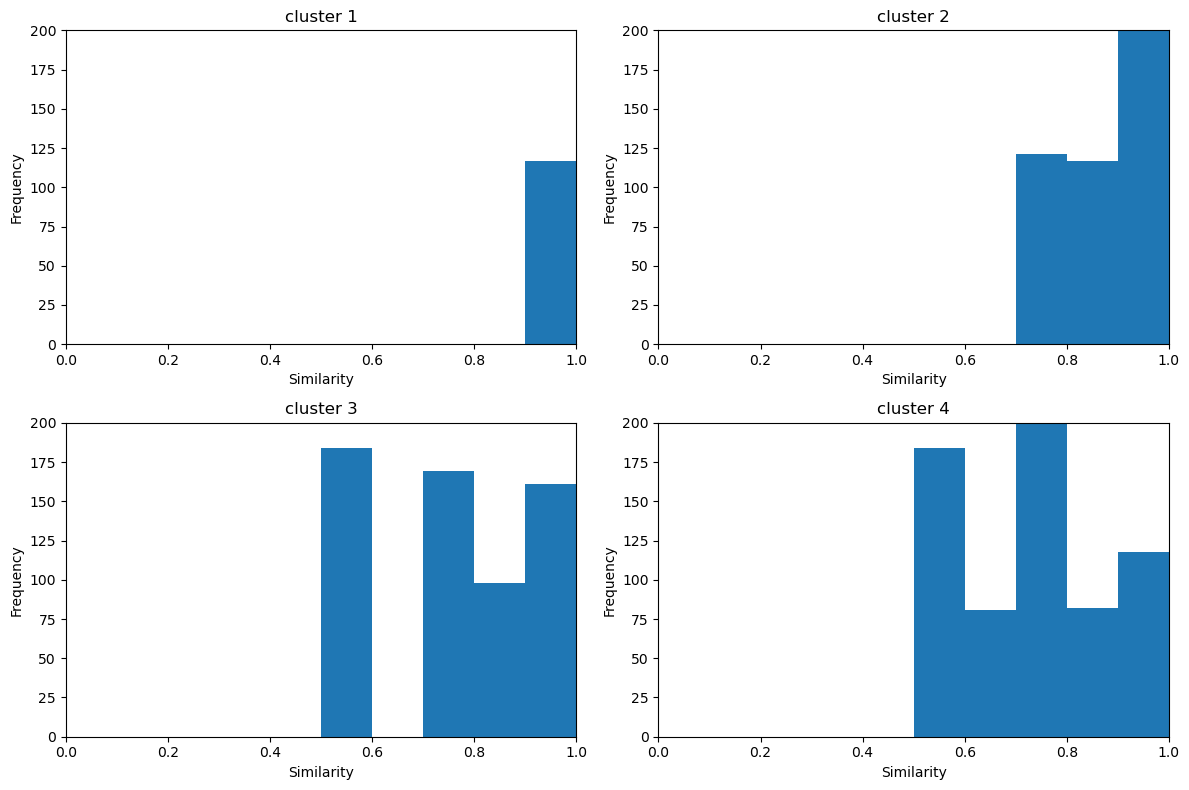

In [89]:
range_values = (0, 1)
num_bins = 10
max_frequency = 200


fig, axs = plt.subplots(2, 2, figsize=(12, 8))


for i in range(1, 5):
    labels = MD_km28[str(i)].predict(MD)
    similarities = MD_km28[str(i)].transform(MD).min(axis=1)
    row = (i - 1) // 2
    col = (i - 1) % 2

    axs[row, col].hist(similarities, bins=num_bins, range=range_values)
    axs[row, col].set_xlabel('Similarity')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].set_title('cluster {}'.format(i))

    axs[row, col].set_xlim(range_values)
    axs[row, col].set_ylim(0, max_frequency)


    axs[row, col].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.tight_layout()
plt.show()

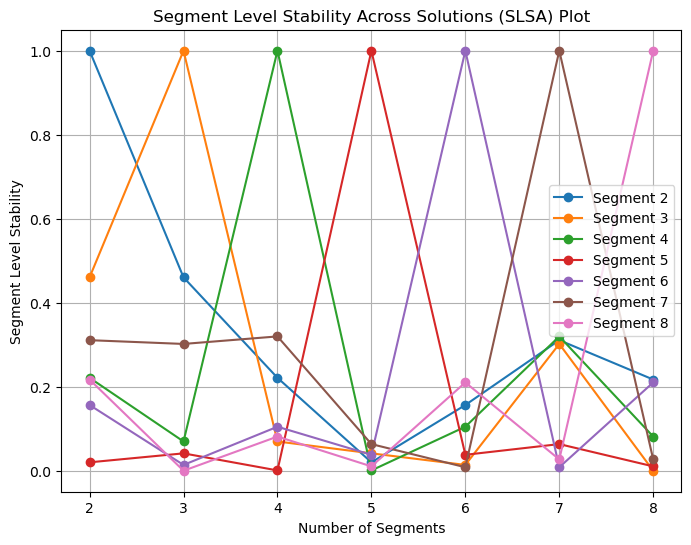

In [90]:
num_segments = range(2, 9)

segment_stability = []
for segment in range(2, 9):
    labels_segment = MD_km28[str(segment)].predict(MD)
    segment_stability.append(labels_segment)

plt.figure(figsize=(8, 6))
for i, segment in enumerate(range(2, 9)):
    plt.plot(num_segments, [np.mean(segment_stability[i] == labels) for labels in segment_stability], marker='o', label=f'Segment {segment}')

plt.xlabel('Number of Segments')
plt.ylabel('Segment Level Stability')
plt.title('Segment Level Stability Across Solutions (SLSA) Plot')
plt.xticks(num_segments)
plt.legend()
plt.grid(True)

plt.show()

In [93]:
np.random.seed(1234)
k_values = range(2, 9)
MD_m28 = []
for k in k_values:
    model = KMeans(n_clusters=k, random_state=1234)
    model.fit(MD.values)
    iter_val = model.n_iter_
    converged = True
    k_val = k
    k0_val = k
    log_likelihood = -model.inertia_
    n_samples, _ = MD.shape
    aic = -2 * log_likelihood + 2 * k
    bic = -2 * log_likelihood + np.log(n_samples) * k
    labels = model.labels_
    counts = np.bincount(labels)
    probs = counts / float(counts.sum())
    class_entropy = entropy(probs)
    icl = bic - class_entropy
    
    MD_m28.append((iter_val, converged, k_val, k0_val, log_likelihood, aic, bic, icl))
MD_m28 = pd.DataFrame(MD_m28, columns=['iter', 'converged', 'k', 'k0', 'logLik', 'AIC', 'BIC', 'ICL'])

print(MD_m28)

C:\Users\cherukuri\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  
C:\Users\cherukuri\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  
C:\Users\cherukuri\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  
C:\Users\cherukuri\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  
C:\Users\cherukuri\AppData\Local\ana

   iter  converged  k  k0       logLik          AIC          BIC          ICL
0     8       True  2   2 -2145.503727  4295.007454  4305.570225  4304.904547
1     9       True  3   3 -1818.717659  3643.435318  3659.279475  3658.209672
2     7       True  4   4 -1602.986015  3213.972030  3235.097572  3233.753684
3    13       True  5   5 -1435.324786  2880.649571  2907.056500  2905.465473
4    10       True  6   6 -1332.150483  2676.300966  2707.989280  2706.201149
5    10       True  7   7 -1249.233890  2512.467780  2549.437480  2547.530062
6    10       True  8   8 -1191.580948  2399.161896  2441.412982  2439.379225


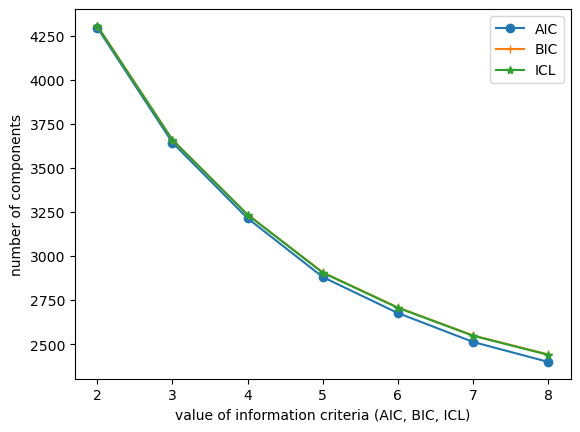

In [103]:
plt.plot(MD_m28['k'],MD_m28['AIC'],label='AIC',marker='o')
plt.plot(MD_m28['k'],MD_m28['BIC'],label='BIC',marker= '+')
plt.plot(MD_m28['k'],MD_m28['ICL'],label='ICL',marker= '*')
plt.xlabel('value of information criteria (AIC, BIC, ICL)')
plt.ylabel('number of components')
plt.legend()

In [105]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=1234)
kmeans.fit(MD)
kmeans_clusters = kmeans.predict(MD)

gmm = GaussianMixture(n_components=k, random_state=1234)
gmm.fit(MD)
gmm_clusters = gmm.predict(MD)

results = pd.DataFrame({'kmeans': kmeans_clusters, 'mixture': gmm_clusters})

MD_m4 = MD[results['mixture'] == 3] 

k4_m4 = KMeans(n_clusters=k, random_state=1234)
k4_m4.fit(MD_m4)
k4_m4_clusters = k4_m4.predict(MD_m4)

results_m4 = pd.DataFrame({'kmeans': k4_m4_clusters, 'mixture': 3})

print(pd.crosstab(results['kmeans'], results['mixture']))
print(pd.crosstab(results['kmeans'], results_m4['kmeans']))

C:\Users\cherukuri\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  
C:\Users\cherukuri\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  
C:\Users\cherukuri\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  


mixture    0    1    2    3
kmeans                     
0         99    5  253    7
1          0  211   24    5
2        500    0    0   33
3         22   38    0  256
kmeans   0   1   2   3
kmeans                
0       29  10  17  23
1       18   8  12  11
2       45  14  31  19
3       29   5  15  15


In [107]:
gum = GaussianMixture(n_components=4)
gum.fit(MD)

GaussianMixture(n_components=4)

In [110]:
log_likelihood_m = gum.score(MD)
log_likelihood_m 

9.456781748071885

In [111]:
gum1 = GaussianMixture(n_components=4)
gum1.fit(MD)

log_likelihood_m1 = gum1.score(MD)

Log-likelihood for MD.m4a: 9.456781748071885
Log-likelihood for MD.m4: 3.6427464011765815


In [113]:
print("Log-likelihood for MD.m:", log_likelihood_m)
print("Log-likelihood for MD.m1:", log_likelihood_m1)

Log-likelihood for MD.m: 9.456781748071885
Log-likelihood for MD.m1: 3.6427464011765815


## Using Mixtures of Regression Models

In [127]:
df['Like'] = pd.to_numeric(df['Like'], errors='coerce')

# Count the occurrences of each value in the 'Like' column
like_counts = df['Like'].value_counts()

# Reverse the order of the counts
like_counts_reversed = like_counts.iloc[::-1]

print("Reversed Like Counts:")
print(like_counts_reversed)

Reversed Like Counts:
Like
-1.0     58
-2.0     59
-4.0     71
-3.0     73
 1.0    152
 4.0    160
 0.0    169
 2.0    187
 3.0    229
Name: count, dtype: int64


In [144]:
# Ensure 'Like' is treated as numeric values
df['Like'] = pd.to_numeric(df['Like'], errors='coerce')
df['Like.n'] = 6 - df['Like']

# Construct the formula string dynamically
first_11_columns = df.columns[:11]
formula_string = 'Like ~ ' + '+ '.join(first_11_columns)

##print("Formula String:")
print(formula_string)



Like ~ yummy + convenient + spicy + fattening + greasy + fast + cheap + tasty + expensive + healthy + disgusting


In [149]:
x= dmatrices(formula_string, data=df)[1]
print(x)

[[1. 0. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 0. 0.]
 [1. 0. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 1. 0. 1.]]


In [160]:
np.random.seed(1234)
a= dmatrix(x.design_info, data=df)##
b= dmatrix('Like', data=df)

In [162]:
n_components = 2
n_init = 10
verbose = False
n_rep=10

model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=verbose)
MD_reg2 = model.fit(a, b)

print(MD_reg2)
cluster_sizes = np.bincount(model.predict(a))

print("Cluster sizes:")
for i, size in enumerate(cluster_sizes):
    print(f"{i+1}: {size}")

GaussianMixture(n_components=2, n_init=10, verbose=False)
Cluster sizes:
1: 468
2: 985


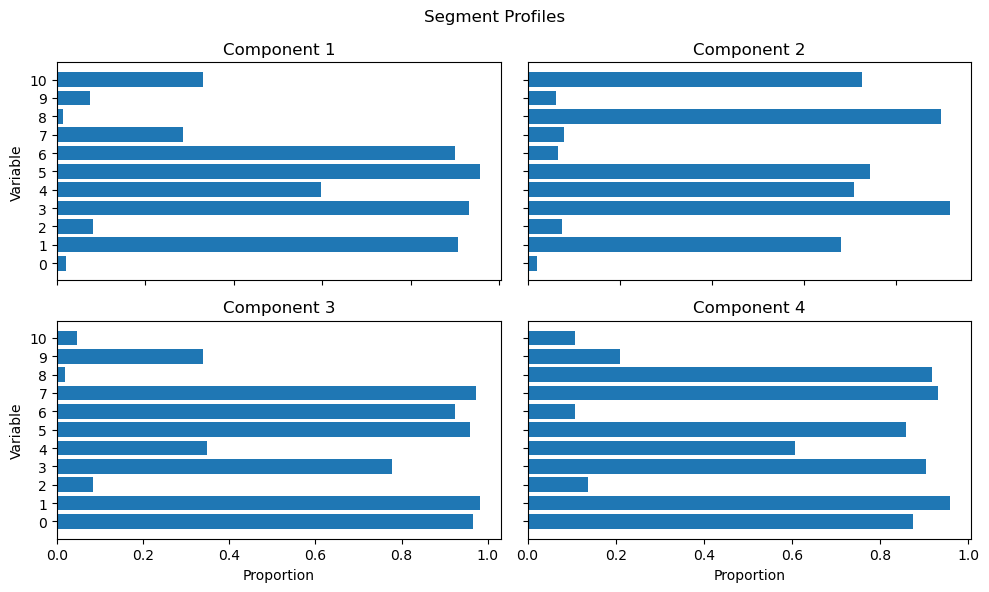

In [163]:
kmeans = MD_km28['4']

labels = kmeans.labels_

MD_mean = MD.groupby(labels).mean()

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs[0, 0].barh(range(MD_mean.shape[1]), MD_mean.iloc[0])
axs[0, 0].set_title('Component 1')
axs[0, 1].barh(range(MD_mean.shape[1]), MD_mean.iloc[1])
axs[0, 1].set_title('Component 2')
axs[1, 0].barh(range(MD_mean.shape[1]), MD_mean.iloc[2])
axs[1, 0].set_title('Component 3')
axs[1, 1].barh(range(MD_mean.shape[1]), MD_mean.iloc[3])
axs[1, 1].set_title('Component 4')

for ax in axs.flat:
    ax.set(ylabel='Variable', xlabel='Proportion')
    ax.set_yticks(range(MD_mean.shape[1]))
    ax.set_yticklabels(MD.columns)

for ax in axs.flat:
    ax.label_outer()

fig.suptitle('Segment Profiles')

fig.tight_layout()

plt.show()

C:\Users\cherukuri\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  


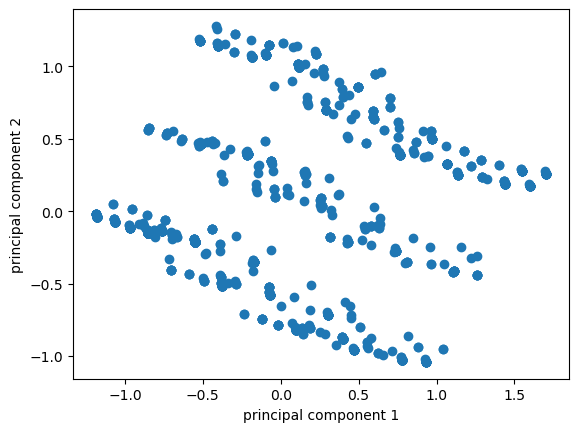

In [165]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(MD)

pca = PCA(n_components=2)
MD_pca = pca.fit_transform(MD)

fig, ax = plt.subplots()

ax.scatter(MD_pca[:, 0], MD_pca[:, 1])
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
plt.show()

C:\Users\cherukuri\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  


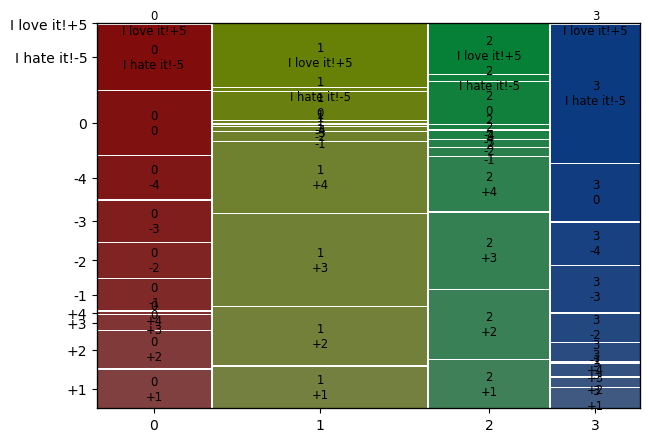

In [204]:
def labelling(x):
    df[x] = LabelEncoder().fit_transform(df[x])
    return df

cat = ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting']

for i in cat:
    labelling(i)
df
df_eleven = df.loc[:,cat]
df_eleven
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(df_eleven)
df['cluster_num'] = kmeans.labels_ 
crosstab =pd.crosstab(df['cluster_num'],df['Like'])
##crosstab = pd.DataFrame(crosstab,columns=['I hate it!-5','-4','-3','-2','-1','0','1','2','3','4','I love it!+5'])
#Reordering cols
df
## crosstab = crosstab['I hate it!-5','-4','-3','-2','-1','0','1','2','3','4','I love it!+5']
##crosstab 
plt.rcParams['figure.figsize'] = (7,5)
mosaic(crosstab.stack())
plt.show()

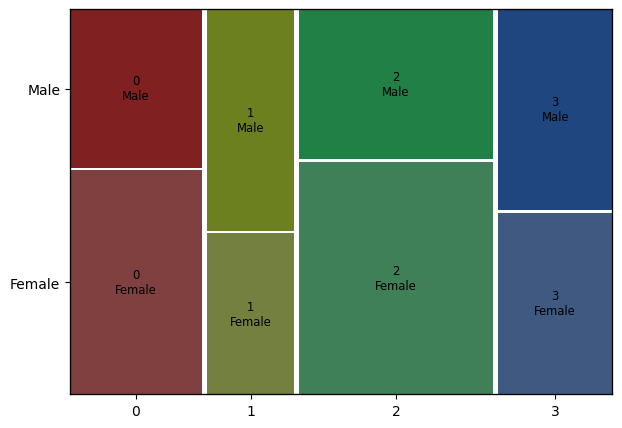

In [197]:
MD_k4=MD_km28['4']
k4 = MD_k4.labels_

ct = pd.crosstab(k4, df['Gender'])
ct
mosaic(ct.stack(),gap=0.01)

plt.show()

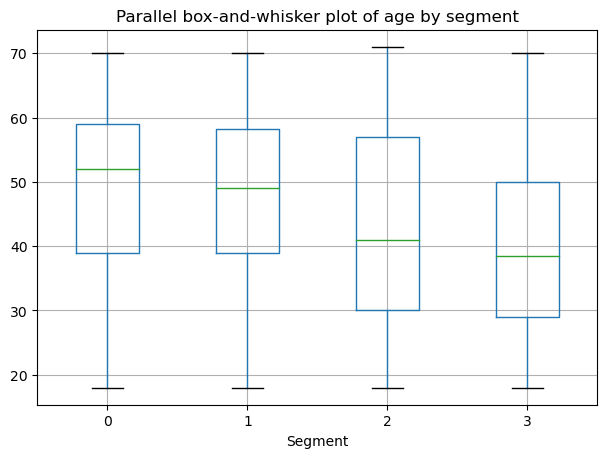

In [198]:
df = pd.DataFrame({'Segment': k4, 'Age': df['Age']})

df.boxplot(by='Segment', column='Age')
plt.title('Parallel box-and-whisker plot of age by segment')
plt.suptitle('')
plt.show()

In [202]:
df

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,0,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,0,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,0,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,4,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,3,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,No,Yes,No,Yes,Yes,No,No,No,Yes,No,Yes,I hate it!-5,47,5,Male
1449,Yes,Yes,No,Yes,No,No,Yes,Yes,No,Yes,No,+2,36,4,Female
1450,Yes,Yes,No,Yes,No,Yes,No,Yes,Yes,No,No,+3,52,3,Female
1451,Yes,Yes,No,No,No,Yes,Yes,Yes,No,Yes,No,+4,41,0,Male


In [206]:
df['VisitFrequency'] = LabelEncoder().fit_transform(df['VisitFrequency'])
visit = df.groupby('cluster_num')['VisitFrequency'].mean()
visit = visit.to_frame().reset_index()
visit

,cluster_num,VisitFrequency
0,0,2.809061
1,1,2.584483
2,2,2.540123
3,3,2.679167


In [207]:
df['Like'] = LabelEncoder().fit_transform(df['Like'])
Like = df.groupby('cluster_num')['Like'].mean()
Like = Like.to_frame().reset_index()
Like

,cluster_num,Like
0,0,5.423948
1,1,3.794828
2,2,3.808642
3,3,6.775000


In [210]:
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
Gender = df.groupby('cluster_num')['Gender'].mean()
Gender = Gender.to_frame().reset_index()
Gender

,cluster_num,Gender
0,0,0.407767
1,1,0.398276
2,2,0.521605
3,3,0.579167


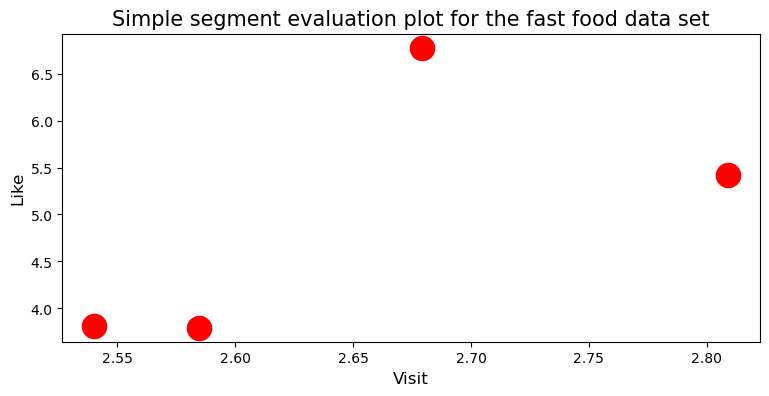

In [212]:
segment = Gender.merge(Like, on='cluster_num', how='left').merge(visit, on='cluster_num', how='left')
segment
plt.figure(figsize = (9,4))
sb.scatterplot(x = "VisitFrequency", y = "Like",data=segment,s=400, color="r")
plt.title("Simple segment evaluation plot for the fast food data set",fontsize = 15) 
plt.xlabel("Visit", fontsize = 12) 
plt.ylabel("Like", fontsize = 12) 
plt.show()